### Import library

In [1]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
from jiwer import wer, cer
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from PIL import Image
from sklearn.model_selection import train_test_split
from IPython.display import display
from torchvision import transforms
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Hằng số TIME_STEPS
TIME_STEPS = 240
resize_max_width = 512
resize_max_height = 128  # Thêm chiều cao tối đa
# Danh sách ký tự
CHAR_LIST = [' ', '!', '"', '#', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'À', 'Á', 'Â', 'Ê', 'Ô', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'è', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'ĩ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'ẩ', 'ẫ', 'ậ', 'ắ', 'ằ', 'ẳ', 'ẵ', 'ặ', 'ẹ', 'ẻ', 'ẽ', 'ế', 'Ề', 'ề', 'Ể', 'ể', 'ễ', 'Ệ', 'ệ', 'ỉ', 'ị', 'ọ', 'ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'ổ', 'ỗ', 'ộ', 'ớ', 'ờ', 'Ở', 'ở', 'ỡ', 'ợ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'ừ', 'ử', 'ữ', 'ự', 'ỳ', 'ỵ', 'ỷ', 'ỹ']

### Display image from dataset

In [4]:
def display_image_from_dataset(dataset, idx):
    # Lấy item từ dataset
    item = dataset[idx]
    
    # Lấy tensor ảnh từ dictionary
    img_tensor = item['image']  # Định dạng: CxHxW
    
    # Chuyển tensor về numpy và đổi định dạng về HxWxC để hiển thị
    img = img_tensor.numpy()  # Chuyển từ tensor sang numpy
    img = img.squeeze()  # Loại bỏ chiều kênh (1xHxW -> HxW) vì ảnh là grayscale
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img)
    display(img)
    
    # In thêm thông tin
    print(f"Label: {item['original_text']}")
    print(f"Label Length: {item['label_length']}")
    print(f"Input Length: {item['input_length']}")

In [5]:
# Hàm mã hóa nhãn
def encode_to_labels(label, char_list=CHAR_LIST):
    return [char_list.index(char) for char in label if char in char_list]

### Build dataset

In [6]:
class OCRDataset(Dataset):
    def __init__(self, dataset_name, split, data_dir="/kaggle/input/ttcs-dataset/TongHopData", merge=False, simple_resize=False):
        # Thiết lập thông số kích thước mới
        self.target_height = 128  # Chiều cao cố định
        self.target_width = 512 # Giảm max_width từ 1024 xuống 512
        self.padding_value = 255  # Giá trị padding (màu trắng)
        self.time_steps = 240
        self.resize_height = 118
        self.resize_max_width = 2167
        self.dataset_name = dataset_name
        self.split = split
        self.data_dir = data_dir
        self.merge = merge
        self.char_list = CHAR_LIST
        self.supported_extensions = (".jpg", ".jpeg", ".png", ".JPG")
        self.simple_resize = simple_resize
        # Danh sách các bộ dữ liệu
        self.all_datasets = ["Data_line", "Data_line_cu", "Data_paragraph", "Data_word"]

        # Tính toán max_label_len và thu thập dữ liệu
        max_label_len = 0
        data_frames = []
        for dataset in self.all_datasets:
            csv_path = os.path.join(self.data_dir, f"{dataset}.csv")
            if os.path.exists(csv_path):
                df = pd.read_csv(csv_path)
                for label in df["label"]:
                    label = str(label)
                    encoded_label = encode_to_labels(label, self.char_list)
                    max_label_len = max(max_label_len, len(encoded_label))
                df["dataset"] = dataset
                data_frames.append(df)
            else:
                raise FileNotFoundError(f"CSV file {csv_path} not found")

        self.max_label_len = max_label_len

        # Xử lý merge dataset
        if self.merge:
            self.data = pd.concat(data_frames, ignore_index=True)
        else:
            if dataset_name not in self.all_datasets:
                raise ValueError(f"dataset_name must be one of {self.all_datasets}")
            self.data = pd.read_csv(os.path.join(self.data_dir, f"{dataset_name}.csv"))
            self.data["dataset"] = dataset_name

        # Chia tập train/val/test theo tỷ lệ 80/15/5
        self._split_data()

    def _split_data(self):
        """Chia dữ liệu thành train/val/test với tỷ lệ 80/15/5"""
        train_data, temp_data = train_test_split(self.data, test_size=0.2, random_state=42, shuffle=True)
        val_data, test_data = train_test_split(temp_data, test_size=0.25, random_state=42, shuffle=True)  # 0.25*0.2 = 0.05 (5%)
        
        if self.split == "train":
            self.data = train_data
        elif self.split == "val":
            self.data = val_data
        elif self.split == "test":
            self.data = test_data
        elif self.split == "merge":
            self.data = train_data + val_data + test_data
        else:
            raise ValueError("Split must be 'train', 'val', or 'test'")
        
        self.data = self.data.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def _load_and_preprocess_image(self, img_path):
        """Tải và tiền xử lý ảnh giống cách làm trong class đầu tiên"""
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image {img_path}")
        height, width = img.shape
        # Resize theo chiều cao = 118 và giữ nguyên tỉ lệ
        new_width = int(self.resize_height / height * width)
        img = cv2.resize(img, (new_width, self.resize_height))
        # Pad chiều rộng sang phải để đủ resize_max_width
        if img.shape[1] < self.resize_max_width:
            pad_width = self.resize_max_width - img.shape[1]
            img = np.pad(img, ((0, 0), (0, pad_width)), 'median')
        else:
            img = cv2.resize(img, (self.resize_max_width, self.resize_height))
        if self.simple_resize:
            img = img.astype(np.float32) / 255
            return np.expand_dims(img, axis=0)
        # Thêm làm nghiêng nếu là train
        if self.split == 'train':
            angle = np.random.uniform(-2, 2)
            center = (self.resize_max_width // 2, self.resize_height // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            img = cv2.warpAffine(img, M, (self.resize_max_width, self.resize_height),
                                 borderMode=cv2.BORDER_REPLICATE,
                                 flags=cv2.INTER_LINEAR)
        
            # Tiền xử lý
            img = cv2.GaussianBlur(img, (5,5), 0)
        img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                    cv2.THRESH_BINARY_INV, 11, 4)
        
        img = img.astype(np.float32) / 255
        return np.expand_dims(img, axis=0)

    def __getitem__(self, idx):
        # Lấy thông tin từ dataframe
        row = self.data.iloc[idx]
        img_name, label, dataset = row["id"], str(row["label"]), row["dataset"]
        
        # Tìm và kiểm tra ảnh
        img_path = self._find_image_path(img_name, dataset)
        
        # Tiền xử lý ảnh
        img = self._load_and_preprocess_image(img_path)
        
        # Mã hóa nhãn
        encoded_label = encode_to_labels(label, self.char_list)
        label_length = len(encoded_label)
        padded_label = np.pad(encoded_label, (0, self.max_label_len - label_length),
                            'constant', constant_values=0)
        
        return {
            'image': torch.from_numpy(img),
            'label': torch.from_numpy(padded_label).long(),
            'label_length': label_length,
            'input_length': self.time_steps,
            'original_text': label
        }

    def _find_image_path(self, img_name, dataset):
        """Tìm đường dẫn ảnh với các extension hỗ trợ"""
        image_dir = os.path.join(self.data_dir, dataset)
        for ext in self.supported_extensions:
            potential_path = os.path.join(image_dir, f"{img_name}{ext}")
            if os.path.exists(potential_path):
                return potential_path
        raise FileNotFoundError(f"Image {img_name} not found in {image_dir}")

In [7]:
train_dataset = OCRDataset('Data_line_cu', 'train', '/kaggle/input/ttcs-dataset/TongHopData', False, False)
val_dataset = OCRDataset('Data_line_cu', 'val', '/kaggle/input/ttcs-dataset/TongHopData', False, False)
train_dataset += OCRDataset('Data_line', 'train', '/kaggle/input/ttcs-dataset/TongHopData', False)
val_dataset += OCRDataset('Data_line', 'val', '/kaggle/input/ttcs-dataset/TongHopData', False)
batch_size = 32
train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True)
val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [8]:
print(len(train_dataset))

7306


In [9]:
print(len(val_dataset))

1371


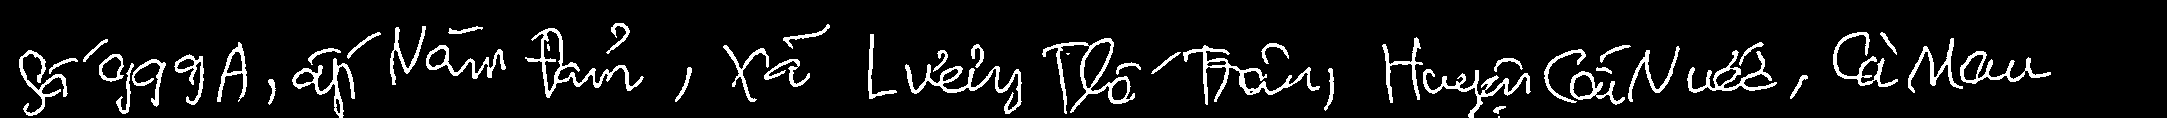

Label: Số 999A, ấp Năm Đảm, Xã Lương Thế Trân, Huyện Cái Nước, Cà Mau
Label Length: 62
Input Length: 240
None


In [10]:
print(display_image_from_dataset(train_dataset,5))

### Model Bidirection LSTM from Scratch

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.W_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_c = nn.Linear(input_size + hidden_size, hidden_size)
        self.W_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_t, states):
        h_prev, c_prev = states
        combined = torch.cat((x_t, h_prev), dim=1)
        i_t = torch.sigmoid(self.W_i(combined))
        f_t = torch.sigmoid(self.W_f(combined))
        o_t = torch.sigmoid(self.W_o(combined))
        g_t = torch.tanh(self.W_c(combined))
        c_t = f_t * c_prev + i_t * g_t
        h_t = o_t * torch.tanh(c_t)
        h_t = self.dropout(h_t)
        return h_t, (h_t, c_t)

In [12]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, dropout=0.2):
        super().__init__()
        self.forward_lstm = LSTM(input_dim, hidden_size, dropout=dropout)
        self.backward_lstm = LSTM(input_dim, hidden_size, dropout=dropout)
        self.hidden_size = hidden_size

    def forward(self, x):
        batch_size, seq_len, _ = x.size()

        h_f = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_f = torch.zeros(batch_size, self.hidden_size, device=x.device)
        forward_outputs = []

        for t in range(seq_len):
            h_f, (h_f, c_f) = self.forward_lstm(x[:, t, :], (h_f, c_f))
            forward_outputs.append(h_f)
        forward_outputs = torch.stack(forward_outputs, dim=1)

        h_b = torch.zeros(batch_size, self.hidden_size, device=x.device)
        c_b = torch.zeros(batch_size, self.hidden_size, device=x.device)
        backward_outputs = []

        for t in reversed(range(seq_len)):
            h_b, (h_b, c_b) = self.backward_lstm(x[:, t, :], (h_b, c_b))
            backward_outputs.insert(0, h_b)
        backward_outputs = torch.stack(backward_outputs, dim=1)

        outputs = torch.cat((forward_outputs, backward_outputs), dim=2)
        return outputs


### Model Resnet18 From Scratch

In [13]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.create_layer(ResidualBlock, 64, 2, stride=1)
        self.layer2 = self.create_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.create_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.create_layer(ResidualBlock, 512, 2, stride=2)
        self.pool = nn.AdaptiveAvgPool2d((1, None))

    def create_layer(self, block, out_channels, blocks, stride):
        layers = []
        layers.append(block(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        return x

### Attention Mechanism

In [14]:
class SelfAttention(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.W_query = nn.Linear(input_size, hidden_size, bias=False)
        self.W_key = nn.Linear(input_size, hidden_size, bias=False)
        self.W_value = nn.Linear(input_size, hidden_size, bias=False)
        self.hidden_size = hidden_size

    def forward(self, x):
        # x: (batch, time, input_size)
        queries = self.W_query(x)  # (batch, time, hidden_size)
        keys = self.W_key(x)       # (batch, time, hidden_size)
        values = self.W_value(x)   # (batch, time, hidden_size)

        # Compute attention scores
        attention_scores = torch.bmm(queries, keys.transpose(1, 2))  # (batch, time, time)
        attention_scores = attention_scores / (self.hidden_size ** 0.5)  # Scaling
        attention_weights = F.softmax(attention_scores, dim=-1)  # (batch, time, time)

        # Apply attention weights
        attended = torch.bmm(attention_weights, values)  # (batch, time, hidden_size)
        return attended

### Model CRNN

In [15]:
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()

        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=3),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256), nn.ReLU(),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),

            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512), nn.ReLU(),

            nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=(3, 1)), nn.ReLU(),

            nn.MaxPool2d(kernel_size=(3, 1))
        )
        # self.self_attention = SelfAttention(input_size=1024, hidden_size=512)
        self.rnn1 = BidirectionalLSTM(1024, 512, dropout=0.2)
        self.rnn2 = BidirectionalLSTM(1024, 512, dropout=0.2)

        # Fully connected output
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.cnn(x)  # shape: (batch, channels=1024, height=1, width=time)

        x = x.squeeze(2)  # Remove height dimension -> (batch, channels, time)
        x = x.permute(0, 2, 1)  # (batch, time, channels)
        # x = self.self_attention(x)
        x = self.rnn1(x)
        x = self.rnn2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=2)


### Trainer

In [16]:
lr = 0.001
epochs = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(CHAR_LIST) + 1
blank_idx = num_classes - 1
# + 1 for blank char
model = CRNN(num_classes).to(device)
criterion = nn.CTCLoss(blank=num_classes-1, reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.00005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer = optimizer, gamma = 0.98)
# scheduler = torch.optim.lr_scheduler.StepLR(
#     optimizer,
#     step_size = epochs * 0.6,
#     gamma = 0.1
# )

### Training

In [17]:
def decode_ctc_greedy(output, char_list, blank_idx):
    pred_indices = torch.argmax(output, dim=1)
    decoded_text = []
    prev_idx = blank_idx
    for idx in pred_indices:
        idx = idx.item()
        if idx != blank_idx and idx != prev_idx:
            decoded_text.append(char_list[idx])
        prev_idx = idx
    return ''.join(decoded_text)

In [18]:
def evaluate(model, dataloader, criterion, device, char_list, blank_idx):
    model.eval()
    losses = []
    wers = []
    cers = []

    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            labels = batch['label'].to(device)
            input_lengths = batch['input_length'].to(device)
            label_lengths = batch['label_length'].to(device)

            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)
            loss = criterion(outputs, labels, input_lengths, label_lengths)
            losses.append(loss.item())

            batch_size = outputs.shape[1]
            for i in range(batch_size):
                pred = decode_ctc_greedy(outputs[:, i, :], char_list, blank_idx)
                true_label = labels[i][:label_lengths[i]].tolist()
                gt = ''.join([char_list[idx] for idx in true_label if idx != blank_idx])
                
                wers.append(wer(gt, pred))
                cers.append(cer(gt, pred))

    loss = sum(losses) / len(losses)
    avg_wer = sum(wers) / len(wers)
    avg_cer = sum(cers) / len(cers)
    return loss, avg_wer, avg_cer


In [19]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, device, char_list, blank_idx):
    model = model.to(device) # cần chuyển model sang cuda tránh việc không trùng khớp kiểu dữ liệu
    model.train()
    train_losses = []
    val_losses = []
    best_loss = 1e9
    max_wer = 0
    max_cer = 0
    for epoch in range(epochs):
        batch_train_losses = []
        model.train()
        for train_batch in train_loader:
            images = train_batch['image'].to(device)
            labels = train_batch['label'].to(device)
            input_lengths = train_batch['input_length'].to(device)
            label_lengths = train_batch['label_length'].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.permute(1, 0, 2)
            loss = criterion(outputs, labels, input_lengths, label_lengths)
            loss.backward()
            torch.nn.utils.clip_grad_norm(parameters = model.parameters(), max_norm = 5)
            #clip_grad_norm: dùng để giới hạn gradient nếu chúng vượt ngưỡng cho phép thì sẽ được chuẩn hóa lại
            batch_train_losses.append(loss.item())
            optimizer.step()
        train_loss = sum(batch_train_losses)/len(batch_train_losses)
        train_losses.append(train_loss)
        val_loss, wer, cer = evaluate(model, val_loader, criterion, device, char_list, blank_idx)
        val_losses.append(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'ocr_crnn_best.pt')
            max_wer = wer
            max_cer = cer
        print(f"Epoch: {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | WER: {wer:.4f} | CER: {cer:.4f}")
        scheduler.step()
    return train_losses, val_losses, max_wer, max_cer

In [20]:
train_losses, val_losses, max_wer, max_cer = fit(model, train_loader, val_loader, epochs, criterion, optimizer, scheduler, device, CHAR_LIST, blank_idx)

/tmp/ipykernel_18/302592415.py:23: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(parameters = model.parameters(), max_norm = 5)


Epoch: 1: Train Loss: 3.8646 | Val Loss: 4.1809 | WER: 1.0000 | CER: 1.0000
Epoch: 2: Train Loss: 3.2069 | Val Loss: 3.3513 | WER: 1.0508 | CER: 0.6904
Epoch: 3: Train Loss: 2.1584 | Val Loss: 1.7955 | WER: 0.9411 | CER: 0.4676
Epoch: 4: Train Loss: 1.4723 | Val Loss: 1.4674 | WER: 0.8526 | CER: 0.3754
Epoch: 5: Train Loss: 1.0976 | Val Loss: 1.1646 | WER: 0.7440 | CER: 0.3037
Epoch: 6: Train Loss: 0.9052 | Val Loss: 0.9223 | WER: 0.6193 | CER: 0.2364
Epoch: 7: Train Loss: 0.7806 | Val Loss: 0.8388 | WER: 0.5721 | CER: 0.2116
Epoch: 8: Train Loss: 0.6918 | Val Loss: 0.7306 | WER: 0.5120 | CER: 0.1851
Epoch: 9: Train Loss: 0.6270 | Val Loss: 0.6527 | WER: 0.4557 | CER: 0.1626
Epoch: 10: Train Loss: 0.5770 | Val Loss: 0.6860 | WER: 0.4813 | CER: 0.1677
Epoch: 11: Train Loss: 0.5450 | Val Loss: 0.6136 | WER: 0.4262 | CER: 0.1514
Epoch: 12: Train Loss: 0.5068 | Val Loss: 0.6134 | WER: 0.4306 | CER: 0.1524
Epoch: 13: Train Loss: 0.4796 | Val Loss: 5.9905 | WER: 1.2812 | CER: 0.7232
Epoch: 1

### Display train loss, validation loss

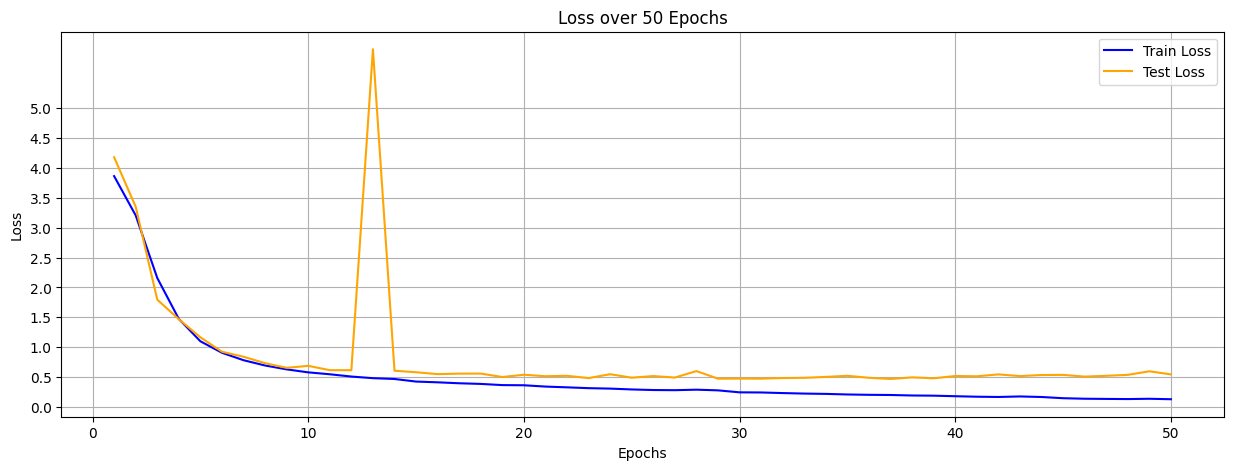

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(15, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, label='Test Loss', color='orange')
plt.title('Loss over 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(ticks=np.arange(0, 5.5, 0.5))
plt.legend()
plt.grid()
plt.show()

In [22]:
print(min(val_losses))

0.4664115597342336


In [23]:
print(max_wer)
print(max_cer)

0.2866405563804227
0.10122672036087162
